# Checkpointing

Your task is to implement checkpointing for a MLP using NumPy.

You are free to use the implementation of a MLP and the backpropagation algorithm that you have developed during lab sessions.

The key takeaway from this task is that with checkpointing we can trade off the computational resources needed to compute the forward pass of the network for the memory requirement needed to perform a backward pass in the network, which is often a major bottleneck when training large networks. In plain english, we can slightly increase the time required for training our network to save some of our GPU's precious memory.

## What is checkpointing?

The aim of checkpointing is to save every $n$-th layer's (e.g. every 2-nd layer's) forward result (instead of saving every layer's forward result as in plain backpropagation) and use these checkpoints for recomputing the forward pass of the network upon doing a backward pass. Checkpoint layers are kept in memory after the forward pass, while the remaining activations are recomputed at most once. After being recomputed, the non-checkpoint layers are kept in memory until they are no longer required.

# What should be done

1. Take the implementation a MLP trained with backpropagation. Analyze the algorithm with respect to the memory that is used by the algorithm with respect to the number of hidden layers.

2. Implement a class NetworkWithCheckpointing that inherits from the Network class defined during lab sessions by:
    a) implementing a method `forward_between_checkpoints` that will recompute the forward pass of the network using one of the checkpointed layers
    b) override the method `backprop` to use only checkpointed layers and otherwise compute the activations using `forward_between_checkpoints` method and keep it in memory until no longer needed.

3. Train your network with checkpoinintg on MNIST. Compare running times and memory usage with respect to the network without checkpointing.


# Implement Checkpointing for a MLP

In [1]:
import random
import numpy as np
from torchvision import datasets, transforms

In [2]:
!wget -nc -O mnist.npz https://s3.amazonaws.com/img-datasets/mnist.npz

File ‘mnist.npz’ already there; not retrieving.


In [3]:
# Let's read the mnist dataset

def load_mnist(path='mnist.npz'):
    with np.load(path) as f:
        x_train, _y_train = f['x_train'], f['y_train']
        x_test, _y_test = f['x_test'], f['y_test']

    x_train = x_train.reshape(-1, 28 * 28) / 255.
    x_test = x_test.reshape(-1, 28 * 28) / 255.

    y_train = np.zeros((_y_train.shape[0], 10))
    y_train[np.arange(_y_train.shape[0]), _y_train] = 1

    y_test = np.zeros((_y_test.shape[0], 10))
    y_test[np.arange(_y_test.shape[0]), _y_test] = 1

    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_mnist()

In [16]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def logsumexp(z):
    c = z.max()
    return c + np.log(np.sum(np.exp(z - c)))

def softmax(z):
    exp = np.exp(z - z.max())
    return exp / np.sum(exp, axis=0)

def softmax_jacobian(inputs):
    return np.array([np.diag(inp) - np.outer(inp, inp) for inp in inputs])

In [17]:
class Network(object):
    def __init__(self, sizes):
        # initialize biases and weights with random normal distr.
        # weights are indexed by target node first
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1: ]]
        self.weights = [np.random.randn(y, x) 
                        for x, y in zip(sizes[: -1], sizes[1: ])]
        self.momentum_w = [np.zeros_like(w) for w in self.weights]
        self.momentum_b = [np.zeros_like(b) for b in self.biases]
        
        self.mem_usage = {}
        
    def feedforward(self, a):
        # Run the network on a mini batch
        a = a.T
        for b, w in zip(self.biases[: -1], self.weights[: -1]):
            a = sigmoid(w @ a + b)
        a = softmax(self.weights[-1] @ a + self.biases[-1])
        return a
    
    def update_mini_batch(self, x_mini_batch, y_mini_batch, eta, gamma, lambd):
        # Update networks weights and biases by applying a single step
        # of gradient descent using backpropagation to compute the gradient.
        # The gradient is computed for a mini_batch.
        # eta: learning rate
        # gamma: momentum parameter
        # lambd: L2 regularization parameter
        nabla_b, nabla_w = self.backprop(x_mini_batch.T, y_mini_batch.T)
        
        # Learning rate should scale with the mini batch size
        # https://stackoverflow.com/questions/53033556
        eta /= len(x_mini_batch)
        
        # L2 regularization here! ('- lambda * w')
        self.momentum_w = [
            gamma * mw - eta * nw - lambd * w
            for w, nw, mw in zip(self.weights, nabla_w, self.momentum_w)
        ]
        # Never regularize the biases
        self.momentum_b = [
            gamma * mb - eta * nb
            for b, nb, mb in zip(self.biases, nabla_b, self.momentum_b)
        ]
        
        self.weights = [w + mw for w, mw in zip(self.weights, self.momentum_w)]
        self.biases = [b + mb for b, mb in zip(self.biases, self.momentum_b)]
        
    def backprop(self, x, y):
        # For an input mini-batch (x,y) return a pair of
        # gradients over biases and gradients over weights
        
        # no transposition here - x and y have already been
        # transposed in the caller function
        afters = [x]
        # skip the last layer to apply softmax instead of sigmoid
        for biases, weights in zip(self.biases[: -1], self.weights[: -1]):
            # add biases before applying sigmoid, because it would normally
            # correspond to a weight with a fixed input of 1
            before = weights @ afters[-1] + biases
            afters += [sigmoid(before)]
        before = self.weights[-1] @ afters[-1] + self.biases[-1]
        afters += [softmax(before)]
        
        if 'afters' not in self.mem_usage:
            self.mem_usage['afters'] = sum(res.nbytes for res in afters)
        
        # First initialize the list of gradient arrays
        nabla_b = []
        nabla_w = []
        
        # Now go backward from the final cost applying backpropagation
        deriv = self.cost_derivative(afters[-1], y)   
        first_iteration = True
        for activation, prev_activation, weights in zip(
            reversed(afters), reversed(afters[: -1]), reversed(self.weights)
        ):
            # don't calculate dL/dg^N and dg^N/df^N separately for the softmax layer
            # no need to calculate the Jacobian matrix - calculate dL/df^N directly
            # in softmax regression with log-loss, this is dL/df^N, *not* dL/dg^N!
            if not first_iteration:
                # now deriv = d(L) / d(g^k)
                # calculate deriv = d(L) / d(f^k)
                # the below is the Hadamard product of the matrices
                assert deriv.shape == activation.shape
                deriv = deriv * (activation * (1 - activation))
            first_iteration = False
            
            # d(L)/d(W^k) = d(L)/d(f^k) @ d(f^k) / d(W^k) = d(L) / d(f^k) @ (g^{k-1})^T
            nabla_w += [deriv @ prev_activation.T]
            # d(L)/d(b^k) = d(L)/d(f^k) @ d(f^k) / d(b^k) = d(L) / d(f^k) @ [1, 1 .., 1]
            nabla_b += [deriv @ np.ones([deriv.shape[1], 1])]
            
            # calculate deriv = d(L) / d(g^{k - 1})
            deriv = weights.T @ deriv
        nabla_b, nabla_w = list(reversed(nabla_b)), list(reversed(nabla_w))
        
        if 'nabla_b' not in self.mem_usage:
            self.mem_usage['nabla_b'] = sum(res.nbytes for res in nabla_b)
        if 'nabla_w' not in self.mem_usage:
            self.mem_usage['nabla_w'] = sum(res.nbytes for res in nabla_w)
        return nabla_b, nabla_w

    def evaluate(self, x_test, y_test):
        # Count the number of correct answers for test_data
        y_pred = np.argmax(self.feedforward(x_test), axis=0)
        y = np.argmax(y_test, axis=1).T
        return np.mean(y_pred == y)
    
    def cost_derivative(self, output_activations, y):
        return output_activations - y
    
    def SGD(self, training_data, epochs, mini_batch_size, eta, gamma, lambd, test_data=None):
        x_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data
        
        for i in range(epochs):
            for x_batch, y_batch in zip(
                np.array_split(x_train, x_train.shape[0] // mini_batch_size),
                np.array_split(y_train, y_train.shape[0] // mini_batch_size)
            ):
                self.update_mini_batch(x_batch, y_batch, eta, gamma, lambd)
            
            if test_data is not None:
                print("Epoch: {0}, Accuracy: {1}".format(i, self.evaluate(x_test, y_test)))
            else:
                print("Epoch: {0}".format(j))
        
        mem = self.mem_usage['afters']
        print(f'Total size of forward results: {mem}B = {sum(self.sizes)} * {mini_batch_size} * 8B')
        mem = self.mem_usage['nabla_b']
        print(f"Total size of biases' gradients: {mem}B = {sum(self.sizes[1: ])} * 8B")
        mem = self.mem_usage['nabla_w']
        prod = sum(a * b for a, b in zip(self.sizes, self.sizes[1: ]))
        print(f"Total size of weights' gradients` {mem}B = {prod} * 8B")

# Memory usage analysis for plain backpropagation
Let's analyze the memory usage of our backpropagation implementation.  
We can quickly see that the only significant memory usage increment is due to these three arrays:  
-`afters`: forward results; size = (sum of layer sizes) * (mini-batch size) * (dtype size)  
-`nabla_b`: biases' gradients; size = (sum of layer sizes) * (dtype size)  
-`nabla_w`: weights' gradients; size = (number of weights) * (dtype size)  
Let's verify that our hypothesis about the sizes is sound:

In [19]:
network = Network([784, 10])
network.SGD((x_train, y_train),epochs=2,mini_batch_size=100,eta=3e-1,gamma=0.9,lambd=3e-5,test_data=(x_test, y_test))

Epoch: 0, Accuracy: 0.8638
Epoch: 1, Accuracy: 0.8432
Total size of forward results: 635200B = 794 * 100 * 8B
Total size of biases' gradients: 80B = 10 * 8B
Total size of weights' gradients` 62720B = 7840 * 8B


In [20]:
assert 635200 == 794 * 100 * 8 and 80 == 10 * 8 and 62720 == 7840 * 8

In [21]:
network = Network([784, 100, 100, 10])
network.SGD((x_train, y_train),epochs=2,mini_batch_size=100,eta=3e-1,gamma=0.9,lambd=3e-5,test_data=(x_test, y_test))

Epoch: 0, Accuracy: 0.8828
Epoch: 1, Accuracy: 0.9252
Total size of forward results: 795200B = 994 * 100 * 8B
Total size of biases' gradients: 1680B = 210 * 8B
Total size of weights' gradients` 715200B = 89400 * 8B


In [22]:
assert 795200 == 994 * 100 * 8 and 1680 == 210 * 8 and 715200 == 89400 * 8

Now, let's focus on networks with layer_sizes array of the form `[784, n, n, 10]`.  
Let's see how the memory usage looks like with varying `n` for the `mini-batch size = 100`.

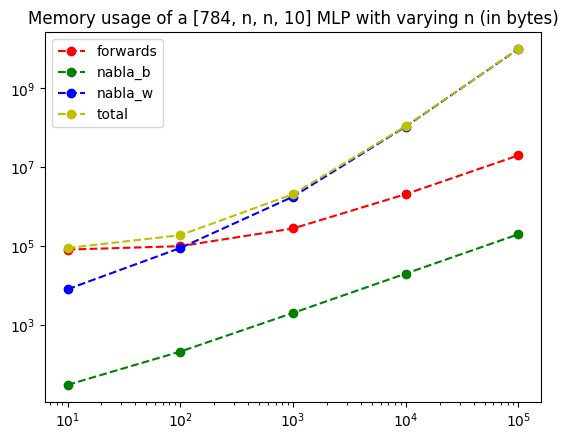

In [23]:
import matplotlib.pyplot as plt

def usage(n: int):
    sizes = [784, n, n, 10]
    mini_batch_size = 100
    prod = sum(a * b for a, b in zip(sizes, sizes[1: ]))
    return sum(sizes) * mini_batch_size, sum(sizes[1: ]), prod

xs = [10, 100, 1000, 10000, 100000]
ys = np.array(list(map(usage, xs)))

plt.xscale('log')
plt.yscale('log')
plt.plot(xs, ys[:, 0], 'ro--', label='forwards')
plt.plot(xs, ys[:, 1], 'go--', label='nabla_b')
plt.plot(xs, ys[:, 2], 'bo--', label='nabla_w')
plt.title('Memory usage of a [784, n, n, 10] MLP with varying n (in bytes)')
plt.plot(xs, ys.sum(axis=1), 'yo--', label='total')
plt.legend();

Clearly, the memory usage is dominated by the weights' gradients.  
We have good measures of reducing this size, but we're not allowed to  
modify other parts of the class in this task. Let's ignore this and focus  
just on the `forwards` array:

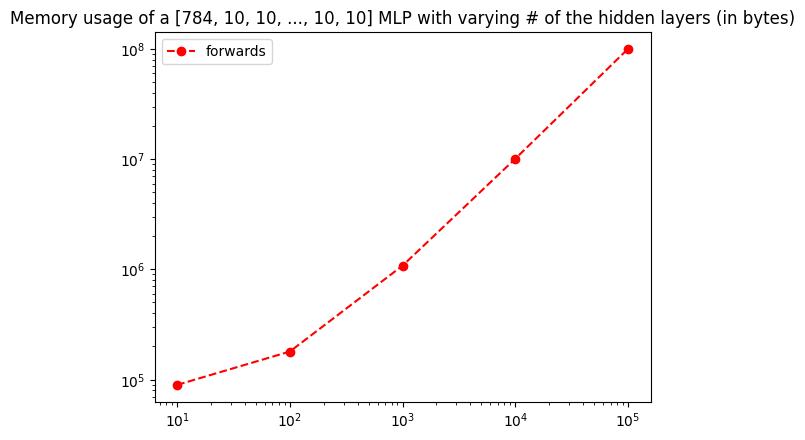

In [24]:
import matplotlib.pyplot as plt

def usage(n: int):
    sizes = [784] + [10 for _ in range(n)] + [10]
    mini_batch_size = 100
    prod = sum(a * b for a, b in zip(sizes, sizes[1: ]))
    return sum(sizes) * mini_batch_size, sum(sizes[1: ]), prod

xs = [10, 100, 1_000, 10_000, 100_000]
ys = np.array(list(map(usage, xs)))

plt.xscale('log')
plt.yscale('log')
plt.plot(xs, ys[:, 0], 'ro--', label='forwards')
plt.title('Memory usage of a [784, 10, 10, ..., 10, 10] MLP with varying # of the hidden layers (in bytes)')
plt.legend();

The behavior is, as expected, linear. We will try to reduce that to  
O(sqrt(n)) by implementing checkpointing and choosing the appropriate step size  

In [56]:
class NetworkWithCheckpointing(Network):
    def __init__(self, sizes, checkpoint_every_nth_layer: int, *args, **kwargs):
        super().__init__(sizes, *args, **kwargs)
        self.k = checkpoint_every_nth_layer
        # checkpoints[i] = vector of activations of the ith layer
        # i.e. checkpoints[0] = x
        self.checkpoints = []
        self.cache = {}
    
    def checkpoint_idx_for_layer(self, layer_idx):
        return layer_idx // self.k
    
    def layer_idx_after_checkpoint(self, checkpoint_idx):
        # for x=checkpoint[0] we calculate weights[0] @ x @ biases[0] etc.
        return checkpoint_idx * self.k
        
    def forward_between_checkpoints(self, x, layer_idx_end, backwards=False):
        if not backwards:
            assert not self.checkpoints
            layer_idx_start = 0
        else:
            checkpoint = self.checkpoint_idx_for_layer(layer_idx_end)
            assert checkpoint == len(self.checkpoints) - 1 >= 0
            layer_idx_start = self.layer_idx_after_checkpoint(checkpoint)
            x = self.checkpoints[checkpoint]
        
        # Run the network on a mini batch
        for i, weights, biases in zip(
            range(layer_idx_start, layer_idx_end),
            self.weights[layer_idx_start: layer_idx_end],
            self.biases[layer_idx_start: layer_idx_end]
        ):
            if not backwards and i % self.k == 0:
                self.checkpoints += [x]
            
            if i not in self.cache:
                x = weights @ x + biases
                if backwards:
                    self.cache[i] = x
            else:
                x = self.cache[i]
                
            if i != self.num_layers - 1:
                x = sigmoid(x)
            else:
                x = softmax(x)
        # here we would have i == layer_idx_end - 2
        # simulate making the next iteration of the loop (i.e. i == layer_idx_end - 1)
        # and make a checkpoint if necessary
        if not backwards and (layer_idx_end - 1) % self.k == 0:
            self.checkpoints += [x]
            
        return x

    def backprop(self, x, y):
        # For an input mini-batch (x,y) return a pair of
        # gradients over biases and gradients over weights
        gN = self.forward_between_checkpoints(x, self.num_layers)
        
        if 'afters' not in self.mem_usage:
            self.mem_usage['afters'] = sum(res.nbytes for res in self.checkpoints)
        
        # First initialize the list of gradient arrays
        nabla_b = []
        nabla_w = []
        
        # Now go backward from the final cost applying backpropagation
        deriv = self.cost_derivative(gN, y)
        first_iteration = True
        for i in range(self.num_layers - 1, 0, -1):
            activation = self.forward_between_checkpoints(x, i, backwards=True)
            if i % self.k == 0:
                layer_redundant = self.layer_idx_after_checkpoint(len(self.checkpoints) - 1)
                to_del = {layer for layer in self.cache if layer > layer_redundant}
                self.checkpoints.pop()
                for layer in to_del:
                    del self.cache[layer]
                
            prev_activation = self.forward_between_checkpoints(x, i - 1, backwards=True)
                
            weights = self.weights[i - 1]
            
            # don't calculate dL/dg^N and dg^N/df^N separately for the softmax layer
            # no need to calculate the Jacobian matrix - calculate dL/df^N directly
            # in softmax regression with log-loss, this is dL/df^N, *not* dL/dg^N!
            if not first_iteration:
                # now deriv = d(L) / d(g^k)
                # calculate deriv = d(L) / d(f^k)
                # the below is the Hadamard product of the matrices
                assert deriv.shape == activation.shape
                deriv = deriv * (activation * (1 - activation))
            first_iteration = False
            
            # d(L)/d(W^k) = d(L)/d(f^k) @ d(f^k) / d(W^k) = d(L) / d(f^k) @ (g^{k-1})^T
            nabla_w += [deriv @ prev_activation.T]
            # d(L)/d(b^k) = d(L)/d(f^k) @ d(f^k) / d(b^k) = d(L) / d(f^k) @ [1, 1 .., 1]
            nabla_b += [deriv @ np.ones([deriv.shape[1], 1])]
            
            # calculate deriv = d(L) / d(g^{k - 1})
            deriv = weights.T @ deriv
        self.checkpoints.pop()
        assert not self.checkpoints
        assert len(self.cache) <= self.k
        self.cache.clear()
        
        nabla_b, nabla_w = list(reversed(nabla_b)), list(reversed(nabla_w))
        if 'nabla_b' not in self.mem_usage:
            self.mem_usage['nabla_b'] = sum(res.nbytes for res in nabla_b)
        if 'nabla_w' not in self.mem_usage:
            self.mem_usage['nabla_w'] = sum(res.nbytes for res in nabla_w)
        return nabla_b, nabla_w
    
    # Not modifying this function - only the print statements
    def SGD(self, training_data, epochs, mini_batch_size, eta, gamma, lambd, test_data=None):
        x_train, y_train = training_data
        if test_data:
            x_test, y_test = test_data
        
        for i in range(epochs):
            for x_batch, y_batch in zip(
                np.array_split(x_train, x_train.shape[0] // mini_batch_size),
                np.array_split(y_train, y_train.shape[0] // mini_batch_size)
            ):
                self.update_mini_batch(x_batch, y_batch, eta, gamma, lambd)
            
            if test_data is not None:
                print("Epoch: {0}, Accuracy: {1}".format(i, self.evaluate(x_test, y_test)))
            else:
                print("Epoch: {0}".format(j))
        
        mem = self.mem_usage['afters']
        print(f'Total size of forward results: {mem}B = {sum(self.sizes[::self.k])} * {mini_batch_size} * 8B')
        mem = self.mem_usage['nabla_b']
        print(f"Total size of biases' gradients: {mem}B = {sum(self.sizes[1: ])} * 8B")
        mem = self.mem_usage['nabla_w']
        prod = sum(a * b for a, b in zip(self.sizes, self.sizes[1: ]))
        print(f"Total size of weights' gradients` {mem}B = {prod} * 8B")

In [57]:
sizes = [784, 100, 100, 100, 10]
network = NetworkWithCheckpointing(sizes, checkpoint_every_nth_layer=3)
network.SGD((x_train, y_train),epochs=2, mini_batch_size=100,eta=3e-1,gamma=0.9,lambd=3e-5,test_data=(x_test, y_test))

Epoch: 0, Accuracy: 0.8843
Epoch: 1, Accuracy: 0.9292
Total size of forward results: 707200B = 884 * 100 * 8B
Total size of biases' gradients: 2480B = 310 * 8B
Total size of weights' gradients` 795200B = 99400 * 8B


In [59]:
assert 707200 == 884 * 100 * 8 and 2480 == 310 * 8 and 795200 == 99400 * 8

Let's once again state our hypothesis and verify it. 
The memory consumption of this implementation is the highest at the beginning,  
when we have to store all the checkpoints and two last activations for  
gradient calculation. Putting aside the two activations, the model should store  
as much as `sum(layer_sizes[:: step]) * (mini-batch size) * (dtype size)` bytes.
Is it really true?

In [60]:
n = 16
sizes = [784] + [100 for _ in range(n)] + [10]
step = int(np.sqrt(n))
network = NetworkWithCheckpointing(sizes, checkpoint_every_nth_layer=step)
network.SGD((x_train, y_train),epochs=1,mini_batch_size=100,eta=3e-1,gamma=0.9,lambd=3e-5,test_data=(x_test, y_test))

Epoch: 0, Accuracy: 0.1009
Total size of forward results: 947200B = 1184 * 100 * 8B
Total size of biases' gradients: 12880B = 1610 * 8B
Total size of weights' gradients` 1835200B = 229400 * 8B


In [62]:
assert 947200 == 1184 * 100 * 8

It seems like it indeed. I tested this relation for multiple architectures,  
but decided not to keep all the intermediate results in this final notebook.  
So, the relation of memory usage of the plain backpropagation algorithm to the  
checkpointing one is given by `sum(layer_sizes) / sum(layer_sizes[:: step])`.  
We can clearly see that if the layers are similiar in size, by choosing `step = sqrt(n)`,  
we can reduce the memory usage to sub-linear:

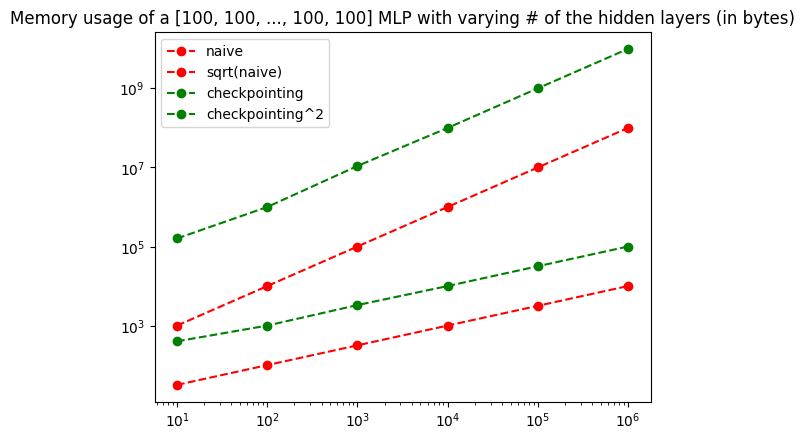

In [63]:
def usage(n, step):
    # yes, we could just multiply
    layer_sizes = [100 for _ in range(n)]
    return sum(layer_sizes), sum(layer_sizes[:: step])

xs = [10, 100, 1_000, 10_000, 100_000, 1_000_000]
ys = np.array(list(map(lambda x: usage(x, int(np.sqrt(x))), xs)))

plt.xscale('log')
plt.yscale('log')
plt.plot(xs, ys[:, 0], 'ro--', label='naive')
plt.plot(xs, np.sqrt(ys[:, 0]), 'ro--', label='sqrt(naive)')
plt.plot(xs, ys[:, 1], 'go--', label='checkpointing')
plt.plot(xs, ys[:, 1] ** 2, 'go--', label='checkpointing^2')
plt.title('Memory usage of a [100, 100, ..., 100, 100] MLP with varying # of the hidden layers (in bytes)')
plt.legend();

Mind the log scales! We can see clearly that `checkpointing ~ sqrt(naive)` and `checkpointing^2 ~ naive`  
in terms of memory usage, asymptotically (for storing the list of forward results).  
Thus, we achieved a sub-linear-memory backpropagation implementation.  
The results in standard scale and for inputs of the same order:

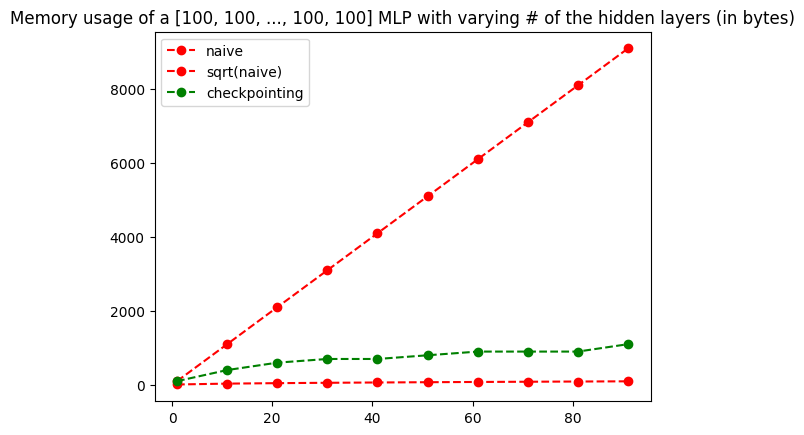

In [64]:
xs = np.arange(1, 100, 10)
ys = np.array(list(map(lambda x: usage(x, int(np.sqrt(x))), xs)))

# plt.yscale('log')
plt.plot(xs, ys[:, 0], 'ro--', label='naive')
plt.plot(xs, np.sqrt(ys[:, 0]), 'ro--', label='sqrt(naive)')
plt.plot(xs, ys[:, 1], 'go--', label='checkpointing')
plt.title('Memory usage of a [100, 100, ..., 100, 100] MLP with varying # of the hidden layers (in bytes)')
plt.legend();

# Running time analysis

In [67]:
%%time
network = Network([784, 100, 100, 100, 10])
network.SGD((x_train, y_train),epochs=5,mini_batch_size=100,eta=3e-1,gamma=0.9,lambd=3e-5,test_data=(x_test, y_test))

Epoch: 0, Accuracy: 0.9087
Epoch: 1, Accuracy: 0.9326
Epoch: 2, Accuracy: 0.9432
Epoch: 3, Accuracy: 0.9496
Epoch: 4, Accuracy: 0.9494
Total size of forward results: 875200B = 1094 * 100 * 8B
Total size of biases' gradients: 2480B = 310 * 8B
Total size of weights' gradients` 795200B = 99400 * 8B
CPU times: user 1min 32s, sys: 1min 18s, total: 2min 51s
Wall time: 26.8 s


In [66]:
%%time
network = NetworkWithCheckpointing([784, 100, 100, 100, 10], checkpoint_every_nth_layer=2)
network.SGD((x_train, y_train),epochs=5,mini_batch_size=100,eta=3e-1,gamma=0.9,lambd=3e-5,test_data=(x_test, y_test))

Epoch: 0, Accuracy: 0.9024
Epoch: 1, Accuracy: 0.9173
Epoch: 2, Accuracy: 0.936
Epoch: 3, Accuracy: 0.9523
Epoch: 4, Accuracy: 0.9493
Total size of forward results: 715200B = 894 * 100 * 8B
Total size of biases' gradients: 2480B = 310 * 8B
Total size of weights' gradients` 795200B = 99400 * 8B
CPU times: user 1min 34s, sys: 1min 1s, total: 2min 36s
Wall time: 19.8 s


The above converge nicely. Running time of the checkpointing version is `94s`, whereas  
the plain backpropagation version finshed in `92s` (CPU time).  
The running times are basically the same, but we saved some memory - `715kB` compared to `875kB`.
But this is a very small network. To see the power of checkpointing, let's use a 'longer' architecture:

In [68]:
arch = [784, 100, 100, 100, 100, 100, 100, 100, 100, 10]

In [72]:
%%time
network = Network(arch)
network.SGD((x_train, y_train),epochs=5,mini_batch_size=100,eta=3e-1,gamma=0.9,lambd=3e-5,test_data=(x_test, y_test))

Epoch: 0, Accuracy: 0.101
Epoch: 1, Accuracy: 0.101
Epoch: 2, Accuracy: 0.4378
Epoch: 3, Accuracy: 0.9088
Epoch: 4, Accuracy: 0.9159
Total size of forward results: 1275200B = 1594 * 100 * 8B
Total size of biases' gradients: 6480B = 810 * 8B
Total size of weights' gradients` 1195200B = 149400 * 8B
CPU times: user 3min 22s, sys: 3min 11s, total: 6min 34s
Wall time: 1min 5s


In [73]:
assert 1275200 == 1594 * 100 * 8 and 6480 == 810 * 8 and 1195200 == 149400 * 8

In [71]:
%%time
network = NetworkWithCheckpointing(arch, checkpoint_every_nth_layer=3)
network.SGD((x_train, y_train),epochs=5,mini_batch_size=100,eta=3e-1,gamma=0.9,lambd=3e-5,test_data=(x_test, y_test))

Epoch: 0, Accuracy: 0.4021
Epoch: 1, Accuracy: 0.6271
Epoch: 2, Accuracy: 0.7844
Epoch: 3, Accuracy: 0.8862
Epoch: 4, Accuracy: 0.9064
Total size of forward results: 795200B = 994 * 100 * 8B
Total size of biases' gradients: 6480B = 810 * 8B
Total size of weights' gradients` 1195200B = 149400 * 8B
CPU times: user 3min 49s, sys: 2min 52s, total: 6min 41s
Wall time: 50.9 s


In [74]:
assert 787200 == 984 * 100 * 8 and 6480 == 810 * 8 and 1195200 == 149400 * 8

Here the ratio is `229s/202s = 1.13` - we could argue about statistical significance of that,  
but in general small (linear) penalties are expected, because of the caching between two consecutive  
checkpoints that we have implemented.

Thus, by implementing checkpointing, we can reduce the memory consumption of  
the backpropagation algorithm, but at the cost of increased computation time.